# Inaugural Project

Import relevant packages and methods, set magics:

In [51]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy import optimize
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The solutions to all questions are organized around a class containing methods for the individual utility, individual tax burden, population average tax burden, and the solution to the household problem. All corresponding functions and the class with innitial values of parameters are defined below.

In [52]:
def u_func(model,c,p_h):
    """ class utility function returns utility for given 
    consumption level and housing quality stated as housing price
    
    Args:
        
        model: class attributes
        c: consumption
        p_h: housing quality stated as housing price
         
    Returns:
    
        utility
    
    """
    return c**(1-model.phi)*p_h**model.phi 

In [53]:
def t_func(model,p_h):
    """class tax function calculates total tax burden 
    for given housing price p_h
  
    Args:

        model: class attributes
        p_h: housing price
   
   Returns:
    
        individual tax burden
        
    """
    return model.tau_g*(p_h*model.epsilon)+model.tau_p*max((p_h*model.epsilon)-model.p_bar,0)

In [54]:
def t_avrg_func(model, N):
    """Class average tax function returns average tax burden for
    N random draws of cash in hand from lognormal distribution
    
    Args:

        model: class attributes
        N: number of draws from lognormal distribution
   
   Returns:
    
        average tax burden across N individuals
        model.M: saves draws from distribution
        model.p_h_list: saves list of optimal housing prices for M draws
        
    """
    np.random.seed(1)
    M = np.random.lognormal(mean=-0.4, sigma=0.35, size=N)
    
    p_h_list = []
    t_list = []
    for m in M:
        model.m = m
        model.solve()
        t_list.append(model.t)
        p_h_list.append(model.p_h)
   
    model.t_avrg = sum(t_list)/N
    
    #for distribution plots M and h
    model.M = M
    model.p_h_list = p_h_list 
    
    return model.t_avrg

In [55]:
def solve(model):
    """solve function minimzes negative utility and saves 
    optimal values of consumption, housing, and corresponding tax burden
    
    Args:
        
        model: class attributes

    Returns (saves):
    
        model.c: optimal consumption of class
        model.p_h: optimal housing quality stated as house price of class
        model.u: utility for optimal consumption and housing
        model.t: tax burden corresponding to optimal consumption and housing of class
    
    """
    # a. objective function (to minimize) 
    obj = lambda x: -model.u_func(x[0],x[1]) # minimize -> negtive of utility
        
    # b. constraints and bounds
    budget_constraint = lambda x: model.m-x[0]-(model.r*x[1]+model.tau_g*(x[1]*model.epsilon)+model.tau_p*max((x[1]*model.epsilon)-model.p_bar,0)) # violated if negative
    constraints = ({'type':'ineq','fun':budget_constraint})
        
    # c. call solver
    x0 = [model.m/2,model.m/2]    #initial guess
    sol = optimize.minimize(obj,x0,method='SLSQP',constraints=constraints)
        
    # d. save
    model.c = sol.x[0]
    model.p_h = sol.x[1]
    model.u = model.u_func(model.c,model.p_h)
    model.t = model.t_func(model.p_h)

In [56]:
class HousingClass:
    """Creates class for household problem, 
    initiates default attributes as stated in question 1,
    includes functions defined above """ 
    def __init__(self):
        
        self.m = 0.5
        self.phi = 0.3
        self.epsilon = 0.5
        self.r = 0.03
        self.tau_g = 0.012
        self.tau_p = 0.004
        self.p_bar = 3
            
    solve = solve
    u_func = u_func
    t_func = t_func
    t_avrg_func = t_avrg_func

# Question 1

Create a class for question 1 and calls the solver method described above to solve the houshold problem:

In [57]:
q1 = HousingClass()
q1.solve()
print(f'Optimal Consumption = {q1.c:.5f}, Optimal Housing Quality = {q1.p_h:.5f}, Utility = {q1.u:.5f}')

Optimal Consumption = 0.35005, Optimal Housing Quality = 4.16529, Utility = 0.73584


# Question 2

Plot $c*$ and $h*$ as function of $m$ for in the range of 0.4 and 1.5

In [58]:
#create empty lists for optimal consumption values and optimal housing quality values
c_values = []
h_values = []

#create space of possible cash-in-hand values
m_values = np.linspace(0.4,1.5,100)

#loop over possible cash in hand values,designating each m as new m for HousingClass from question 1,
#solving each houshold problem and saving optimal consumption and housing to desginated lists
for m in m_values:
    q1.m = m
    q1.solve()
    c_values.append(q1.c)
    h_values.append(q1.p_h)

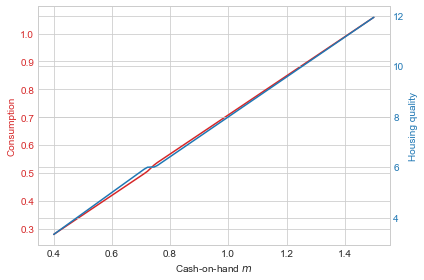

In [71]:
#plot figure with cash on hand values on x-axis 
#and spending on consumption and housing according to optimal solution on y-axes

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Cash-on-hand $m$')
ax1.set_ylabel('Consumption',color=color)
ax1.plot(m_values,c_values,label='Consumption',color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Housing quality', color=color)  # we already handled the x-label with ax1
ax2.plot(m_values,h_values,label='Housing',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

# Question 3

To calculate the average tax burden across 10000 housholds we call the corresponding class function with N=10000

In [60]:
q1.t_avrg_func(10000)

0.03631504578621753

Below we plot the distribution of cash in hand and corresponding optimal housing values by retrieving the values of cash in hand M and list of corresponding optimal housing values p_h_list for the HousingClass of question 1.

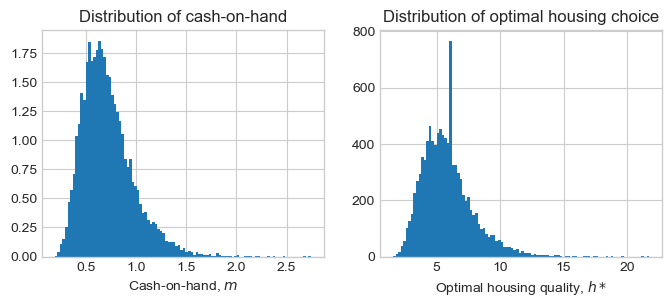

In [61]:
#plotting the distribution of cash on hand
fig = plt.figure(figsize=(8,3), dpi=100)

ax_left = fig.add_subplot(1,2,1)
ax_left.hist(q1.M,bins=100,density=True,label='normal')
ax_left.set_title('Distribution of cash-on-hand')
ax_left.set_xlabel('Cash-on-hand, $m$')
ax_left.grid(True)

ax_right = fig.add_subplot(1,2,2)
ax_right.hist(q1.p_h_list, bins=100)
ax_right.set_title('Distribution of optimal housing choice')
ax_right.set_xlabel('Optimal housing quality, $h*$')

plt.show()


We observe bunching of optimal hosuing choices around 6 mio. dkk which does not correspond similar bunching in the distribution of m. THis is the same plateau observed in the figure of question 2 and can be explained by the cutoff value of the progressive tax.

# Question 4

The new average tax burden is calculated by creating a new housing class q4, setting the new attributes, and calling the average tax burden class function.

In [62]:
q4 = HousingClass()
q4.epsilon = 0.8
q4.tau_g = 0.01
q4.tau_p = 0.009
q4.p_bar = 8

q4.t_avrg_func(10000)

0.04501876791715367

The new average tax burden is higher than before.

# Question 5

To calculate the tax level $\tau^g$ that offsets the rise in tax burden observed in question 4, we first create a new housing class q5 with the required parameter values, second, creating a function calculating the difference between the original low average tax burden and the average tax burden for the new parameters and a variable $\tau^g$, and lastly optimizing to find the $\tau^g$ that minimizes this difference.

In [63]:
q5 = HousingClass()
q5.epsilon = 0.8
q5.tau_p = 0.009
q5.p_bar = 8

In [64]:
def t_avrg_dif_func(tau_g):
    """function calculating the difference between the average tax burden 
    from the first specification in question 3 and specifications with 
    new parameters from question 5 for variable levels of tau_g
    
    Args:
        
        tau_g: tax rate

    Returns:
    
        t_avrg_dif: difference between original q1 and new q5 average tax burden

    """  
    global it 
    #set class attribute tau_g in new class equal to input tau_g and call class solver and average tax burden functions
    q5.tau_g = tau_g
    q5.solve()
    q5.t_avrg_func(10000)
   
    #calculate, print, and return absolute difference between q1 and q5 average tax burdens 
    t_avrg_dif = np.abs(q1.t_avrg - q5.t_avrg)
    print(f'{it:3d}: tau_g = {q5.tau_g:.5f}, tax burden difference = {t_avrg_dif:.10f},')
    it+=1
    return t_avrg_dif

In [65]:
obj = lambda x: t_avrg_dif_func(x)    ##set function defined above as objective

bounds = (0,q4.tau_g)     #define bounds for tau_g between 0 and tau_g in q4 specification
x0 = [q4.tau_g]    #tau_g from q4 as initial guess 
it = 0
optimize.minimize_scalar(obj, bracket=None, bounds=bounds, method='bounded', tol=None, options=None)     #call solver

  0: tau_g = 0.00382, tax burden difference = 0.0164033594,
  1: tau_g = 0.00618, tax burden difference = 0.0060320577,
  2: tau_g = 0.00764, tax burden difference = 0.0001263835,
  3: tau_g = 0.00854, tax burden difference = 0.0033477439,
  4: tau_g = 0.00754, tax burden difference = 0.0005296031,
  5: tau_g = 0.00785, tax burden difference = 0.0007015636,
  6: tau_g = 0.00768, tax burden difference = 0.0000372462,
  7: tau_g = 0.00775, tax burden difference = 0.0002907719,
  8: tau_g = 0.00768, tax burden difference = 0.0000241923,
  9: tau_g = 0.00767, tax burden difference = 0.0000179547,
 10: tau_g = 0.00766, tax burden difference = 0.0000593220,
 11: tau_g = 0.00767, tax burden difference = 0.0000048920,
 12: tau_g = 0.00767, tax burden difference = 0.0000081755,


     fun: 4.891998331334191e-06
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 0.0076703023464574655

Setting the tax rate $\tau^g$ to 0.00767 will minimize the added tax burden to 0.000004892.